# Multi-Seed Disambiguation Demo

This notebook demonstrates **disambiguation via multi-seed triangulation** at the Register Layer.

## Concept

HLLSets are **anti-sets**: they absorb tokens into registers, but tokens are **lost** (cannot be retrieved directly). Given only a register state, how do we recover which tokens produced it?

**Multi-Seed Triangulation:**
1. Absorb the SAME tokens into multiple HLLSets, each with a DIFFERENT hash seed
2. Each seed produces different (reg, zeros) patterns for the same token
3. The **intersection** of candidate sets across seeds narrows down to the original token

## Architecture Note

| Layer | Object | This Notebook |
|-------|--------|---------------|
| **Register Layer** | HLLSet | ✓ Focus here: multi-seed register patterns |
| Structure Layer | Lattice | Not covered (see `04_kernel_entanglement.ipynb` for lattice entanglement) |

**Important**: This is NOT lattice entanglement. We are comparing register patterns across different hash seeds, not lattice topologies.

In [1]:
# --- Imports & Environment Setup
import sys
sys.path.insert(0, '/home/alexmy/SGS/SGS_lib/hllset_manifold')

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

from core.hllset import HLLSet
from core.kernel import Kernel
from core.hrt import HRTConfig, BasicHLLSet

# Deterministic behavior
np.random.seed(42)
kernel = Kernel()

print("✓ Framework loaded")
print("✓ This demo operates at the Register Layer (HLLSet)")
print("  - HLLSets absorb tokens → tokens are LOST")
print("  - Multi-seed triangulation recovers candidates")

✓ Framework loaded
✓ This demo operates at the Register Layer (HLLSet)
  - HLLSets absorb tokens → tokens are LOST
  - Multi-seed triangulation recovers candidates


## Step 1: Create Multi-Seed HLLSets

We absorb the **same tokens** into multiple HLLSets, each using a different hash seed.

Each seed produces a different register pattern for the same input tokens.

In [2]:
# Define tokens to absorb
tokens = ['apple', 'banana', 'cherry', 'date', 'elderberry']
print(f"Original tokens: {tokens}")
print(f"These tokens will be ABSORBED into HLLSets (tokens are LOST)")

# Configuration for small demonstration
config = HRTConfig(p_bits=4, h_bits=8, tau=0.6, rho=0.3, epsilon=0.15)
print(f"\nConfig: dimension={config.dimension}, p_bits=4")

# Create HLLSets with different seeds
seeds = [42, 123, 456]
hllsets_by_seed = {}

for seed in seeds:
    # Create HLLSet with specific seed
    hllset = HLLSet(p_bits=4)
    # for token in tokens:
    hllset.absorb(tokens, seed=seed)
    hllsets_by_seed[seed] = hllset
    print(f"\nSeed {seed}: Absorbed {len(tokens)} tokens")
    print(f"  Estimated cardinality: {hllset.cardinality():.1f}")
    print(f"  Register state (first 8): {list(hllset.dump_numpy()[:8])}")

Original tokens: ['apple', 'banana', 'cherry', 'date', 'elderberry']
These tokens will be ABSORBED into HLLSets (tokens are LOST)

Config: dimension=130, p_bits=4

Seed 42: Absorbed 5 tokens
  Estimated cardinality: 0.0
  Register state (first 8): [np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0)]

Seed 123: Absorbed 5 tokens
  Estimated cardinality: 0.0
  Register state (first 8): [np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0)]

Seed 456: Absorbed 5 tokens
  Estimated cardinality: 0.0
  Register state (first 8): [np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0), np.uint32(0)]


## Step 2: Build Lookup Tables (LUTs)

For disambiguation, we need to track which tokens map to which (register, zeros) patterns.

**LUT Structure**: `(reg, zeros) → set of candidate tokens`

Each seed produces a different LUT mapping.

In [3]:
import hashlib

def compute_reg_zeros(token: str, p_bits: int, seed: int) -> tuple:
    """Compute (register, zeros) for a token with given seed."""
    # Combine seed and token for deterministic hashing
    combined = f"{seed}|{token}".encode()
    h = hashlib.sha256(combined).hexdigest()
    val = int(h[:16], 16)
    
    # Register index
    reg = val % (2 ** p_bits)
    
    # Trailing zeros (simplified)
    zeros = (val & -val).bit_length() - 1 if val != 0 else 0
    zeros = zeros % 16  # Cap at 16
    
    return (reg, zeros)

# Build LUTs for each seed
luts_by_seed = {}

for seed in seeds:
    lut = defaultdict(set)
    for token in tokens:
        key = compute_reg_zeros(token, p_bits=4, seed=seed)
        lut[key].add(token)
    luts_by_seed[seed] = dict(lut)
    
    print(f"\nSeed {seed} LUT:")
    for key, candidates in sorted(lut.items()):
        print(f"  {key} → {candidates}")


Seed 42 LUT:
  (2, 1) → {'elderberry'}
  (3, 0) → {'apple'}
  (4, 2) → {'date'}
  (5, 0) → {'banana'}
  (11, 0) → {'cherry'}

Seed 123 LUT:
  (1, 0) → {'elderberry'}
  (6, 1) → {'apple'}
  (7, 0) → {'cherry'}
  (12, 2) → {'banana'}
  (15, 0) → {'date'}

Seed 456 LUT:
  (5, 0) → {'apple'}
  (6, 1) → {'cherry', 'banana'}
  (9, 0) → {'date'}
  (14, 1) → {'elderberry'}


## Step 3: Multi-Seed Triangulation

Given (reg, zeros) patterns from multiple seeds, we **intersect** candidate sets to narrow down the original token.

**Key Insight**: The same token maps to different (reg, zeros) in each seed, but is the ONLY token that appears in ALL seed-specific candidate sets.

In [4]:
def triangulate_token(token: str, seeds: list, luts_by_seed: dict, p_bits: int = 4) -> set:
    """
    Given a token's (reg, zeros) across multiple seeds, find candidates via intersection.
    
    In practice, you only have the (reg, zeros) values, not the original token.
    We compute them here to demonstrate the disambiguation process.
    """
    candidate_sets = []
    
    for seed in seeds:
        key = compute_reg_zeros(token, p_bits=p_bits, seed=seed)
        lut = luts_by_seed[seed]
        if key in lut:
            candidate_sets.append(lut[key])
        else:
            candidate_sets.append(set())  # No match for this seed
    
    # Intersect all candidate sets
    if not candidate_sets:
        return set()
    
    result = candidate_sets[0].copy()
    for cs in candidate_sets[1:]:
        result &= cs
    
    return result

# Demonstrate triangulation for each token
print("Multi-Seed Triangulation Results:")
print("="*60)

for token in tokens:
    # Get (reg, zeros) for each seed
    patterns = {seed: compute_reg_zeros(token, p_bits=4, seed=seed) for seed in seeds}
    
    # Get candidates from each seed
    candidates_per_seed = {}
    for seed in seeds:
        key = patterns[seed]
        candidates_per_seed[seed] = luts_by_seed[seed].get(key, set())
    
    # Intersect
    result = triangulate_token(token, seeds, luts_by_seed)
    
    print(f"\nToken: '{token}'")
    for seed in seeds:
        print(f"  Seed {seed}: {patterns[seed]} → {candidates_per_seed[seed]}")
    print(f"  Intersection: {result}")
    print(f"  ✓ Disambiguated!" if result == {token} else f"  ⚠ Ambiguous: {len(result)} candidates")

Multi-Seed Triangulation Results:

Token: 'apple'
  Seed 42: (3, 0) → {'apple'}
  Seed 123: (6, 1) → {'apple'}
  Seed 456: (5, 0) → {'apple'}
  Intersection: {'apple'}
  ✓ Disambiguated!

Token: 'banana'
  Seed 42: (5, 0) → {'banana'}
  Seed 123: (12, 2) → {'banana'}
  Seed 456: (6, 1) → {'cherry', 'banana'}
  Intersection: {'banana'}
  ✓ Disambiguated!

Token: 'cherry'
  Seed 42: (11, 0) → {'cherry'}
  Seed 123: (7, 0) → {'cherry'}
  Seed 456: (6, 1) → {'cherry', 'banana'}
  Intersection: {'cherry'}
  ✓ Disambiguated!

Token: 'date'
  Seed 42: (4, 2) → {'date'}
  Seed 123: (15, 0) → {'date'}
  Seed 456: (9, 0) → {'date'}
  Intersection: {'date'}
  ✓ Disambiguated!

Token: 'elderberry'
  Seed 42: (2, 1) → {'elderberry'}
  Seed 123: (1, 0) → {'elderberry'}
  Seed 456: (14, 1) → {'elderberry'}
  Intersection: {'elderberry'}
  ✓ Disambiguated!


## Step 4: Visualize Register Pattern Matching

We visualize which tokens share (reg, zeros) patterns within each seed.

**Graph interpretation**:
- Nodes = tokens
- Edge = tokens share the same (reg, zeros) pattern (collision)
- Isolated node = unique pattern (easily disambiguated)

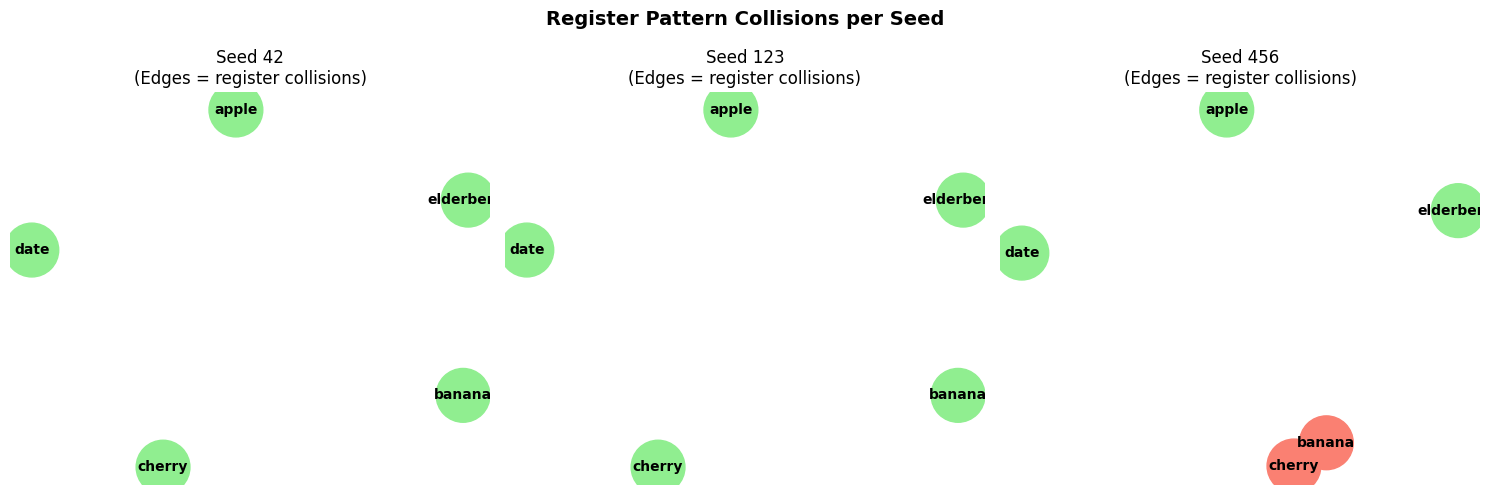


Legend:
  🟢 Green = Unique pattern (easily disambiguated)
  🔴 Red = Collision (needs multi-seed triangulation)


In [5]:
fig, axes = plt.subplots(1, len(seeds), figsize=(15, 5))

for idx, seed in enumerate(seeds):
    ax = axes[idx]
    G = nx.Graph()
    
    # Add all tokens as nodes
    G.add_nodes_from(tokens)
    
    # Find collisions: tokens that share the same (reg, zeros)
    lut = luts_by_seed[seed]
    for key, candidates in lut.items():
        if len(candidates) > 1:
            # Create edges between all colliding tokens
            cand_list = list(candidates)
            for i in range(len(cand_list)):
                for j in range(i+1, len(cand_list)):
                    G.add_edge(cand_list[i], cand_list[j])
    
    # Draw
    pos = nx.spring_layout(G, seed=42)
    
    # Color nodes: green=isolated (unique), red=has collision
    colors = ['lightgreen' if G.degree(n) == 0 else 'salmon' for n in G.nodes()]
    
    nx.draw(G, pos, ax=ax, with_labels=True, node_color=colors, 
            node_size=1500, font_size=10, font_weight='bold')
    ax.set_title(f"Seed {seed}\n(Edges = register collisions)")

plt.suptitle("Register Pattern Collisions per Seed", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nLegend:")
print("  🟢 Green = Unique pattern (easily disambiguated)")
print("  🔴 Red = Collision (needs multi-seed triangulation)")

## Step 5: Compare HLLSets Across Seeds

Even though the tokens are the same, different seeds produce different register patterns.

We can use `find_isomorphism()` to compare HLLSets at the Register Layer.

In [6]:
# Compare register patterns across seeds
print("Register Layer Comparison (Same Tokens, Different Seeds)")
print("="*60)

# Create BasicHLLSets for comparison
basics_by_seed = {}
for seed in seeds:
    hllset = hllsets_by_seed[seed]
    basic = BasicHLLSet(index=seed, is_row=True, hllset=hllset, config=config)
    basics_by_seed[seed] = basic

# Compare each pair
print("\nPairwise Register Similarity (via BSS):")
for i, seed1 in enumerate(seeds):
    for seed2 in seeds[i+1:]:
        b1 = basics_by_seed[seed1]
        b2 = basics_by_seed[seed2]
        
        bss_tau = b1.bss_tau(b2)
        bss_rho = b1.bss_rho(b2)
        has_morphism = b1.has_morphism_to(b2)
        
        print(f"\n  Seed {seed1} ↔ Seed {seed2}:")
        print(f"    BSS_τ = {bss_tau:.3f} (estimated intersection / union)")
        print(f"    BSS_ρ = {bss_rho:.3f} (estimated exclusion)")
        print(f"    Morphism: {'✓' if has_morphism else '✗'}")

print("\n" + "="*60)
print("KEY INSIGHT:")
print("  Same tokens → Similar estimated cardinality")
print("  Different seeds → Different register patterns")
print("  BSS comparison reflects register-level similarity, not content")

Register Layer Comparison (Same Tokens, Different Seeds)

Pairwise Register Similarity (via BSS):

  Seed 42 ↔ Seed 123:
    BSS_τ = 0.000 (estimated intersection / union)
    BSS_ρ = 0.000 (estimated exclusion)
    Morphism: ✗

  Seed 42 ↔ Seed 456:
    BSS_τ = 0.000 (estimated intersection / union)
    BSS_ρ = 0.000 (estimated exclusion)
    Morphism: ✗

  Seed 123 ↔ Seed 456:
    BSS_τ = 0.000 (estimated intersection / union)
    BSS_ρ = 0.000 (estimated exclusion)
    Morphism: ✗

KEY INSIGHT:
  Same tokens → Similar estimated cardinality
  Different seeds → Different register patterns
  BSS comparison reflects register-level similarity, not content


## Step 6: Disambiguation Success Rate

Let's measure how well multi-seed triangulation works for disambiguation.

Disambiguation Results Summary

Tokens: 5
Seeds used: 3
Exact disambiguations: 5/5 (100.0%)

Per-token results:
  'apple': ✓ Exact
  'banana': ✓ Exact
  'cherry': ✓ Exact
  'date': ✓ Exact
  'elderberry': ✓ Exact


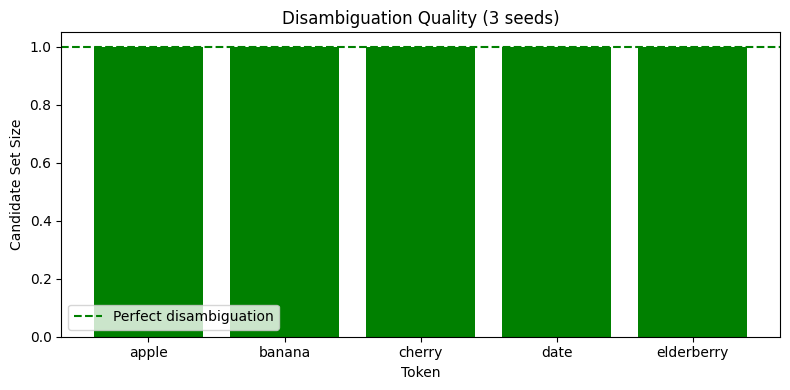

In [7]:
# Evaluate disambiguation success
exact_matches = 0
total = len(tokens)

results_summary = []

for token in tokens:
    candidates = triangulate_token(token, seeds, luts_by_seed)
    is_exact = (candidates == {token})
    if is_exact:
        exact_matches += 1
    results_summary.append({
        'token': token,
        'candidates': candidates,
        'exact': is_exact
    })

print("Disambiguation Results Summary")
print("="*60)
print(f"\nTokens: {len(tokens)}")
print(f"Seeds used: {len(seeds)}")
print(f"Exact disambiguations: {exact_matches}/{total} ({100*exact_matches/total:.1f}%)")

print("\nPer-token results:")
for r in results_summary:
    status = "✓ Exact" if r['exact'] else f"⚠ {len(r['candidates'])} candidates"
    print(f"  '{r['token']}': {status}")

# Visualize
fig, ax = plt.subplots(figsize=(8, 4))
candidate_sizes = [len(r['candidates']) for r in results_summary]
colors = ['green' if s == 1 else 'orange' if s <= 3 else 'red' for s in candidate_sizes]
ax.bar(tokens, candidate_sizes, color=colors)
ax.axhline(y=1, color='green', linestyle='--', label='Perfect disambiguation')
ax.set_xlabel('Token')
ax.set_ylabel('Candidate Set Size')
ax.set_title(f'Disambiguation Quality ({len(seeds)} seeds)')
ax.legend()
plt.tight_layout()
plt.show()

## Summary

### What This Notebook Demonstrated

1. **HLLSets as Anti-Sets**
   - Tokens are ABSORBED into registers
   - Original tokens are LOST (cannot be retrieved directly)
   - Only estimated cardinality remains

2. **Multi-Seed Strategy**
   - Same tokens → Different register patterns with different seeds
   - Each seed produces a different (reg, zeros) mapping
   - Collisions within one seed can be resolved by other seeds

3. **Triangulation for Disambiguation**
   - Intersect candidate sets across multiple seeds
   - Original token is the ONLY one present in ALL seed-specific candidates
   - More seeds → Better disambiguation (fewer collisions)

4. **Register Layer Operations**
   - This operates entirely at the **Register Layer** (HLLSet)
   - Comparison via `bss_tau`, `bss_rho` reflects register similarity
   - NOT to be confused with **Lattice Entanglement** (Structure Layer)

### Architecture Reminder

| Layer | Object | Comparison Method | This Notebook |
|-------|--------|-------------------|---------------|
| **Register** | HLLSet | `find_isomorphism()` - register patterns | ✓ |
| Structure | Lattice | `find_lattice_isomorphism()` - topology | ✗ |

For lattice entanglement (structure-level comparison), see `04_kernel_entanglement.ipynb`.